# Basics of **solt**

In this short tutorial, you will get to know the core concepts behind the **solt** library and also learn how to implement simple data augmentations by yourself.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
import cv2
import os
import glob
import json

np.random.seed(12345)

Solt has several main modules: 

* `base_transforms` - Superclasses and validity checkers
* `core` - Data Streaming classes. The allow to compose transforms into pipelines and serialize them.
* `data` - Data containers (in **solt**, all the data need to be packed into specialized containers)
* `transforms` - Transformations (data augmentations)

The naming convention is in the cell below:

In [2]:
import solt.base_transforms as slb
import solt.transforms as slt
import solt.core as slc
import solt.data as sld

## Typization in data augmentations and DataContainer

Taking look at most of the other fast libraries, we found one particular disadvantage: the transforms do not understand the data and you need to implement some hacks to deal with it. The best library, which has specialized containers for different datatypes is [imgaug](https://github.com/aleju/imgaug), however it is very slow if you have limited resources.

In **solt**, we created a `DataContainer`, which wraps all your data into a single object. Furthermore, the DataContainer enables a possibility to apply the same transformation to multiple images (e.g. to a minibatch, set of masks in instance segmentations etc.). What is needed is just the data and the specification whether it is an image (`I`), mask (`M`), keypoints (`P`) or labels (`L`). An example of creating the data container is given in the cell below:

In [3]:
# Images must be in OpenCV format
test_img_1 = np.zeros((5, 5, 3), dtype=np.uint8)
dc = sld.DataContainer(test_img_1, 'I')

When you have multiple data items, use tuple to supply the data to the `DataContainer`'s constructor. The number of elements in the tuple and the length of the format string must match:

In [4]:
# Images must be in OpenCV format
test_img_2 = np.zeros((5, 5, 3), dtype=np.uint8)
test_img_3 = np.zeros((5, 5, 3), dtype=np.uint8)
dc = sld.DataContainer((test_img_1, test_img_2, test_img_3), 'III')

## Handling the keypoints

We found some difficulties when though about the data augmentations for keypoints (landmarks). One solution, which we found benefitial was to create a container for the keypoints, which also contains the information about the coordinate frame where those keypoints are located:

In [5]:
# Creating fake data
kpts_data = np.array([[0, 0], [0, 1], [1, 0], [2, 0]]).reshape((4, 2))
# Saying the the keypoints need to be within a rectangle HxW, where H=3, W=4 in this case
kpts = sld.KeyPoints(kpts_data, 3, 4)
# Now we can wrap these keypoints into a Data Container:
dc = sld.DataContainer(kpts, 'P')

## Sending the data through the transformations

In **solt**, we have already implemented a large variety of transformations. We always to suggest to use a `Stream` to perform the data augmentations. Let us define a simple stream, which has only one transform  - `RandomFlip`. This transform's expected behaviour is to flip the data around the given axis. Let's perform a horizontal flip:

In [6]:
stream = slc.Stream([
    slt.RandomFlip(p=1, axis=1)
])

### Creating the data

In [7]:
# Plese, not that the image must always have a channel dimension
test_img_4 = np.array([[0, 0, 1],
                       [0, 0, 1],
                       [0, 0, 1]]).reshape(3, 3, 1)

# Masks, however, should have only two dimensions
test_mask_4 = np.array([[1, 0, 0],
                        [1, 0, 0],
                        [1, 0, 0]])

dc = sld.DataContainer((test_img_4, test_mask_4), 'IM')

### Applying the transformations

In [8]:
dc_res = stream(dc)

We can get access to the data within the container as follows:

In [9]:
img_res, mask_res = dc_res.data

The format can also be accessed:

In [10]:
dc_res.data_format

'IM'

### Visualizing the results

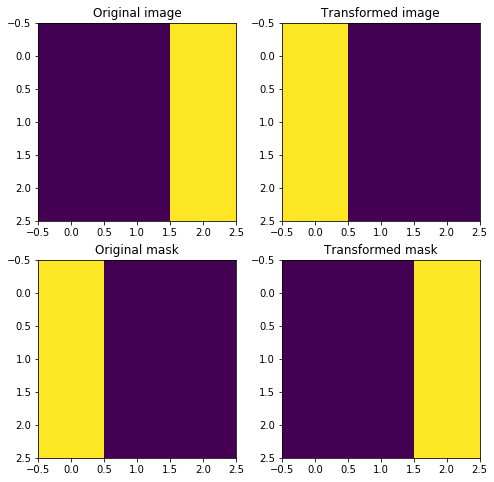

In [11]:
fig, ax = plt.subplots(2, 2, figsize=(8, 8))
ax[0, 0].set_title('Original image')
ax[0, 0].imshow(test_img_4.squeeze())

ax[0, 1].set_title('Transformed image')
ax[0, 1].imshow(img_res.squeeze())

ax[1, 0].set_title('Original mask')
ax[1, 0].imshow(test_mask_4)

ax[1, 1].set_title('Transformed mask')
ax[1, 1].imshow(mask_res)
plt.show()

## Serializing the transformations and streams

We found serialization of the augmentation pipelines to be an important challenge when running experiements. In **solt**, we developed the following API, which allows you to conveniently serialize the whole transformation stream into OrderedDict, which can later be converted into JSON:

In [12]:
stream = slc.Stream([
    slt.RandomFlip(axis=1),
    slt.RandomRotate(rotation_range=(-90, 90)),
])
print(json.dumps(stream.serialize(), indent=4, ))

{
    "RandomFlip": {
        "axis": 1,
        "indices": null,
        "p": 0.5
    },
    "RandomRotate": {
        "indices": null,
        "interpolation": [
            "bilinear",
            "inherit"
        ],
        "p": 0.5,
        "padding": [
            "z",
            "inherit"
        ],
        "range": [
            -90,
            90
        ]
    }
}
